# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
        
# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
    
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep =';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [5]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [6]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [7]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [8]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


looking at the first few rows, the head and the describe we can see that we have missing fields for some columns. and they missing and unknown values have different values thus this needs to be made consistent across the columns and the dataframes.

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
# Identify missing or unknown data values and convert them to NaNs.
azdias.isnull().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [10]:
# Identify missing or unknown data values and convert them to NaNs.
feat_info.missing_or_unknown.value_counts()

[-1]        26
[-1,9]      17
[-1,0]      16
[0]         12
[]          10
[-1,X]       1
[-1,0,9]     1
[XX]         1
[-1,XX]      1
Name: missing_or_unknown, dtype: int64

In [11]:
for index, row in feat_info.iterrows():
    attrib_name = row['attribute']
    data = azdias[attrib_name]

    if row['missing_or_unknown'] != '[]':
        miss_codes = str(row['missing_or_unknown'])[1:-1].split(',')
    else:
        miss_codes = []
    if miss_codes:
        for code in miss_codes:
            # try-except block to capture 'X' and 'XX' codes
            try:
                data = data.replace([int(code)], np.nan)
            except:
                data = data.replace([code], np.nan)

    azdias[attrib_name] = data

In [12]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 205378 non-null float64
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              498903 non-null float64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [13]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 205378 non-null float64
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              498903 non-null float64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          

In [14]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [15]:
# check for an attribute of the missing values has been replaced by nan 
#or if they are present 
feat_info[feat_info["attribute"]=="SEMIO_KRIT"]

,attribute,information_level,type,missing_or_unknown
33,SEMIO_KRIT,person,ordinal,"[-1,9]"


In [16]:
# check the exisiting values in azdias 
azdias.SEMIO_KRIT.value_counts()

7    219847
5    156298
4    144079
6    133049
3    129106
1     54947
2     53895
Name: SEMIO_KRIT, dtype: int64

In [17]:
# get the Series for the missing values in each column 
# i need to subtract the number of rows minus the missing values
azdias.shape[0]-azdias.count()

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

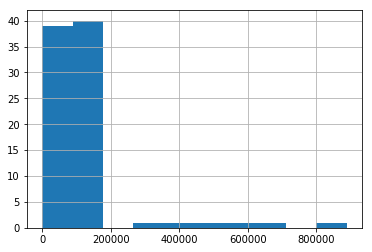

In [18]:
# Histogram for the missing value distribution
(azdias.shape[0] - azdias.count()).hist();

In [19]:
# statistics about the number of missing values in the dataframe
(azdias.shape[0] - azdias.count()).describe()

count        85.000000
mean      98516.811765
std      146604.203317
min           0.000000
25%           0.000000
50%       93148.000000
75%      116515.000000
max      889061.000000
dtype: float64

In [20]:
Q3 = 111196.000000
Q1 = 0
IQR = Q3 - Q1
outliers = 1.5 *(IQR) + Q3
outliers

277990.0

In [21]:
missing_values_count_series = (azdias.shape[0] - azdias.count())

- We can see from the above cell that 50% of the columns had 73969 missing values out of the 891221 rows.
- The maximum number of missing values is 685843 rows.
- The minimum number of missing values is 0 rows.
- The average number of missing values is 76812.541176 rows.

- we can consider the outliers as the columns that had more than 1.5 *(IQR)+Q3 

In [22]:
# the columns that had more missing values than the outliers 
missing_values_count_series[missing_values_count_series>=outliers]

AGER_TYP        685843
GEBURTSJAHR     392318
TITEL_KZ        889061
ALTER_HH        310267
KK_KUNDENTYP    584612
KBA05_BAUMAX    476524
dtype: int64

In [23]:
outliers_cols = missing_values_count_series[missing_values_count_series>=outliers].index.values.tolist()

In [24]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias.drop(columns= outliers_cols, inplace = True)

In [25]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 79 columns):
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          813429 non-null float64
LP_STATUS_FEIN           886367 non-null float64
LP_STATUS_GROB           

In [26]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


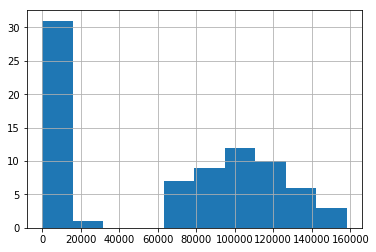

In [27]:
(azdias.shape[0] - azdias.count()).hist();

In [28]:
(azdias.shape[0] - azdias.count()).describe()

count        79.000000
mean      63738.025316
std       54253.866391
min           0.000000
25%           0.000000
50%       93148.000000
75%      108239.500000
max      158064.000000
dtype: float64

#### Discussion 1.1.2: Assess Missing Data in Each Column

- observations regarding the amount of missing data in each column?
    - We can see from the above cell that 50% of the columns had 8.3% missing values.
    - The maximum number of missing values was 76.95%.
    - The minimum number of missing values is 0 rows.
- Are there any patterns in missing values?
    - The number of missing values starting with leading region code has an equal number of missing values or example PLZ8_ANTG1 which corresponds to a family houses in the PLZ8 region have the same number of missing values for all PLZ8_ANTG2, PLZ8_ANTG3, PLZ8_ANTG4, PLZ8_BAUMAX,PLZ8_HHZ and PLZ8_GBZ.
    - HEALTH_TYP, VERS_TYP, SHOPPER_TYP same number of missing values
    - REGIOTYP,KKK
- Which columns were removed from the dataset?
    - AGER_TYP: ager typology. this columns is for a subset of people who embrace a certain cultural movement[definition](https://www.dictionary.com/browse/ager). This column had the highest number of missing values around 76.95% which is expected since it is assoicated with a subset of people that might not be prominent nor applicable to every person in the population.  
    - GEBURTSJAHR: Year of birth. around 44% missing values.
    - KK_KUNDENTYP: Consumer pattern over past 12 months. This column had 65.6% missing values.
    - TITEL_KZ  : Academic title this had around 99% missing values
    - ALTER_HH  : Birthdate around 35 % missing values
    - KBA05_BAUMAX: Most common building type within the microcell with 53% missing values.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [29]:
# How much data is missing in each row of the dataset?
azdias.isnull().sum(axis=1)

0         43
1          0
2          0
3          7
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
19         0
20        10
21         0
22         0
23         8
24        47
25         5
26        19
27         0
28         0
29         2
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    14
891204     0
891205     0
891206     0
891207     0
891208     3
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64

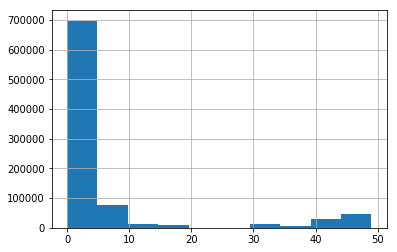

In [30]:
# distribution of missing values in rows
azdias.isnull().sum(axis=1).hist();

In [31]:
azdias.isnull().sum(axis=1).describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

based on the descriptive statistics of the number of missing values in the rows we can see that in 50% of the rows we have 0 missing values(median). while the mean of the values was 5.5 missing values in row and since we know that the median is not affected by outliers so it is a better measure of the data split.
In order t minimize the data loss i will choose a thershold of 10 since the points after 10 has less than 100K points.
the maximum number of missing values in a row was 49 

In [32]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias['missing_values_group'] = azdias.apply(lambda x: 'High' if x.isnull().sum()> 10 else 'Low', axis = 1)

In [33]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,missing_values_group
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High
1,1.0,2,5.0,1,5,2,5,4,5,1,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,Low
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,Low
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,Low
4,3.0,1,5.0,4,3,4,1,3,2,5,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,Low


In [34]:
azdias['missing_values_group'].value_counts()/azdias['missing_values_group'].value_counts().sum()

Low     0.875375
High    0.124625
Name: missing_values_group, dtype: float64

In [35]:
azdias['missing_values_group'].value_counts()

Low     780153
High    111068
Name: missing_values_group, dtype: int64

We can see that 87.5% of the rows have low number of missing values.

In [36]:
azdias_cols = azdias.columns.values.tolist()
azdias_cols

['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'PRAEGENDE_JUGENDJAHRE',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'HH_EINKOMMEN_SCORE',
 'W_KEIT_KIND_HH',
 'WOHNDAUER_2008',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'GEBAEUDETYP',
 'KONSUMNAEHE',
 'MIN_GEBAEUDEJAHR',
 'OST_WEST_KZ',
 'WOHNLAGE',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'CAMEO_INTL_2015',
 'KBA05_ANTG1',
 'K

In [38]:
azdias_missing_low = azdias[azdias.missing_values_group =='Low']
azdias_missing_high = azdias[azdias.missing_values_group =='High']

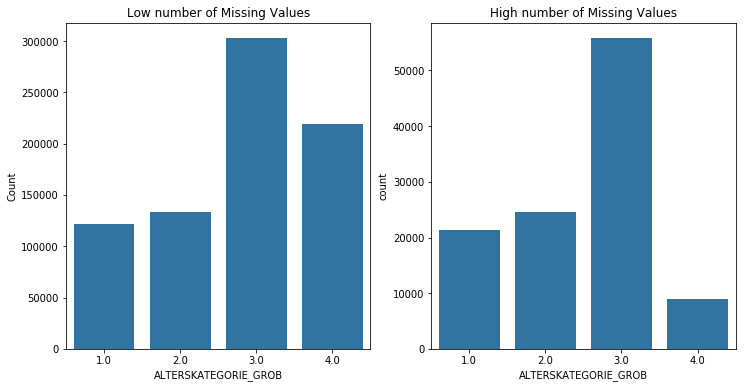

In [39]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def plot_column_count(column):
    
    plt.figure(figsize = [12, 6])
    plt.subplot(1, 2, 1) 
    # low missing values group

    base_color = sns.color_palette()[0]
    sns.countplot(data = azdias_missing_low, x = column, color = base_color)
    plt.ylabel('Count')
    plt.title('Low number of Missing Values')
    # high missing values 
    plt.subplot(1,2,2)
    sns.countplot(data = azdias_missing_high, x = column, color = base_color)
    plt.title('High number of Missing Values')

plot_column_count(azdias_cols[0])


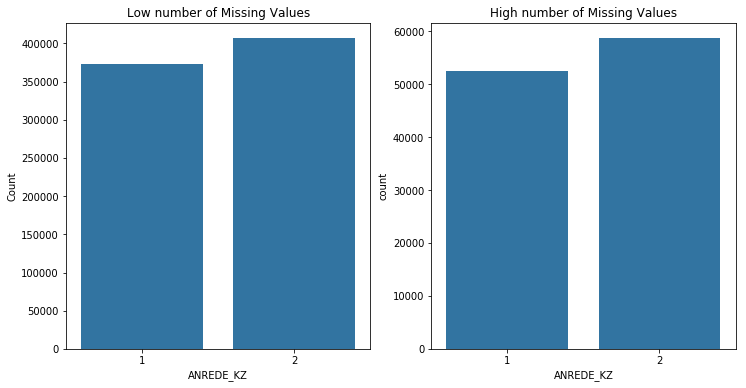

In [40]:
plot_column_count(azdias_cols[1])

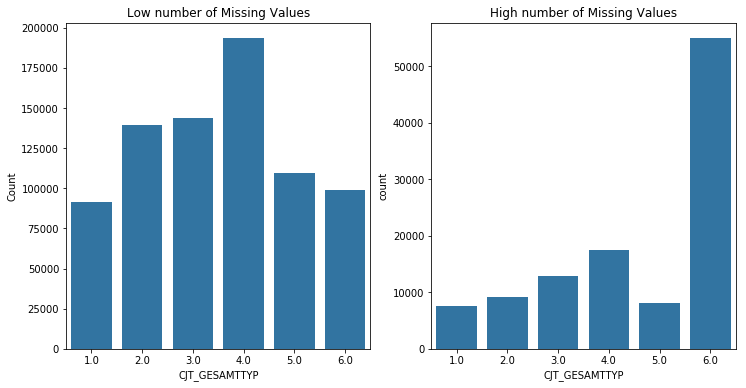

In [41]:
plot_column_count(azdias_cols[2])

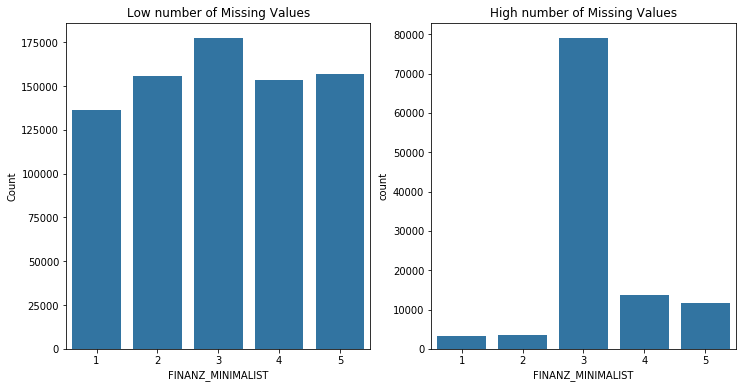

In [42]:
plot_column_count(azdias_cols[3])

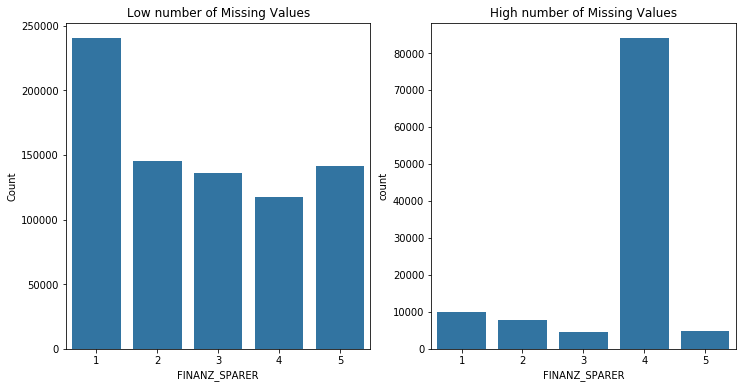

In [43]:
plot_column_count(azdias_cols[4])

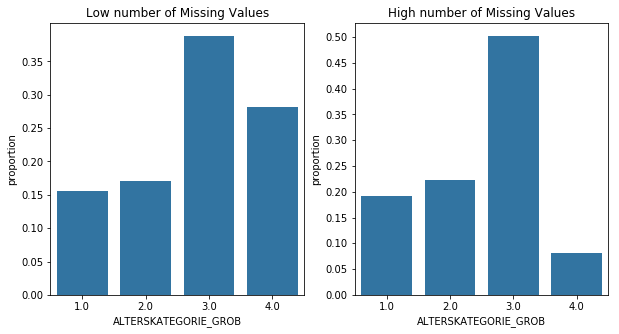

In [44]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
# i am using the percentage instead of the frequency alone to compare
def plot_column_percentage(column):
    
    plt.figure(figsize = [10, 5])
    plt.subplot(1, 2, 1) 
    # low missing values group
    n_points = azdias_missing_low.shape[0]
    max_count = azdias_missing_low[column].value_counts().max()
    max_prop = max_count / n_points
    
    tick_props = np.arange(0, max_prop, 0.05)
    tick_names = ['{:0.2f}'.format(v) for v in tick_props]
    base_color = sns.color_palette()[0]
    sns.countplot(data = azdias_missing_low, x = column, color = base_color)
    plt.yticks(tick_props * n_points, tick_names)
    plt.ylabel('proportion')
    plt.title('Low number of Missing Values')
    # high missing values 
    plt.subplot(1,2,2)
    n_points = azdias_missing_high.shape[0]
    max_count = azdias_missing_high[column].value_counts().max()
    max_prop = max_count / n_points
    
    tick_props = np.arange(0, max_prop, 0.05)
    tick_names = ['{:0.2f}'.format(v) for v in tick_props]
    base_color = sns.color_palette()[0]
    sns.countplot(data = azdias_missing_high, x = column, color = base_color)
    plt.yticks(tick_props * n_points, tick_names)
    plt.ylabel('proportion')
    plt.title('High number of Missing Values')

plot_column_percentage(azdias_cols[0])


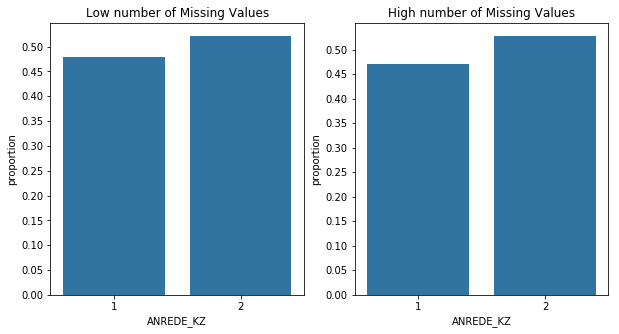

In [45]:
plot_column_percentage(azdias_cols[1])

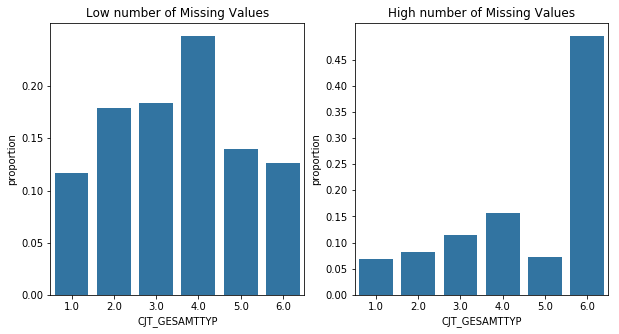

In [46]:
plot_column_percentage(azdias_cols[2])

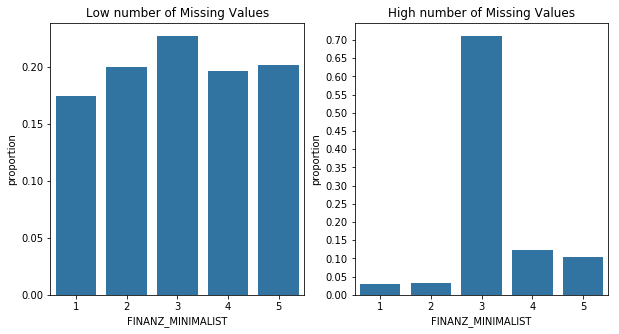

In [47]:
plot_column_percentage(azdias_cols[3])

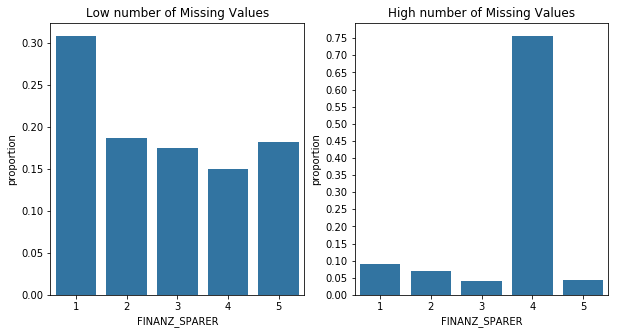

In [48]:
plot_column_percentage(azdias_cols[4])

In [51]:
azdias_missing_low[azdias_cols[:5]].describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER
count,777528.000000,780153.000000,776319.000000,780153.000000,780153.000000
mean,2.797778,1.521235,3.498026,3.050657,2.711548
std,1.019078,0.499549,1.536845,1.378001,1.486898
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,2.000000,2.000000,1.000000
50%,3.000000,2.000000,4.000000,3.000000,3.000000
75%,4.000000,2.000000,5.000000,4.000000,4.000000
max,4.000000,2.000000,6.000000,5.000000,5.000000


In [52]:
azdias_missing_high[azdias_cols[:5]].describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER
count,110812.000000,111068.000000,110048.000000,111068.000000,111068.000000
mean,2.472611,1.528163,4.583854,3.242203,3.590116
std,0.893039,0.499208,1.672360,0.795908,1.005289
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,3.000000,3.000000,4.000000
50%,3.000000,2.000000,5.000000,3.000000,4.000000
75%,3.000000,2.000000,6.000000,3.000000,4.000000
max,4.000000,2.000000,6.000000,5.000000,5.000000


In [53]:
azdias_missing_low.drop(columns =['missing_values_group'], inplace= True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


#### Discussion 1.1.3: Assess Missing Data in Each Row

Are the data with lots of missing values are qualitatively different from data with few or no missing values?)
- as can be seen from the descriptive statistic. some columns differ in the mean and median values while other columns have a similar behavior.
- Since the number of rows that has more lots of missing values then using the percentage to compare would provide a better way to compare. out of the 5 columns chosen. 3 had a different pattern and outlook compared to the ones with low number of missing values. though the mean for these column was close except for one column FINANZ_SPARER.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [54]:
# How many features are there of each data type?
feat_info.type.value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [55]:
# categorical columns while removing dropped columns from then dataframe 
categorical_columns = feat_info[((feat_info.type =='categorical') & (~feat_info.attribute.isin(outliers_cols)))].attribute.values.tolist()
categorical_columns

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [56]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
feat_info[feat_info.attribute.isin(categorical_columns)][['attribute','information_level']]

,attribute,information_level
2,ANREDE_KZ,person
3,CJT_GESAMTTYP,person
10,FINANZTYP,person
12,GFK_URLAUBERTYP,person
13,GREEN_AVANTGARDE,person
17,LP_FAMILIE_FEIN,person
18,LP_FAMILIE_GROB,person
19,LP_STATUS_FEIN,person
20,LP_STATUS_GROB,person
21,NATIONALITAET_KZ,person


In [57]:
# get the value count for each categorical column
for categorical_column in categorical_columns:
    print('for {} column we have the following values'.format(categorical_column))
    print(azdias_missing_low[categorical_column].value_counts().index.values.tolist(),'values')
    print('number of categorical values is: ',len(azdias_missing_low[categorical_column].value_counts().index.values.tolist()))
    print('\n')

for ANREDE_KZ column we have the following values
[2, 1] values
number of categorical values is:  2


for CJT_GESAMTTYP column we have the following values
[4.0, 3.0, 2.0, 5.0, 6.0, 1.0] values
number of categorical values is:  6


for FINANZTYP column we have the following values
[6, 1, 5, 2, 4, 3] values
number of categorical values is:  6


for GFK_URLAUBERTYP column we have the following values
[12.0, 10.0, 8.0, 11.0, 5.0, 4.0, 9.0, 3.0, 1.0, 7.0, 2.0, 6.0] values
number of categorical values is:  12


for GREEN_AVANTGARDE column we have the following values
[0, 1] values
number of categorical values is:  2


for LP_FAMILIE_FEIN column we have the following values
[1.0, 10.0, 2.0, 11.0, 8.0, 7.0, 4.0, 5.0, 9.0, 6.0, 3.0] values
number of categorical values is:  11


for LP_FAMILIE_GROB column we have the following values
[1.0, 5.0, 2.0, 4.0, 3.0] values
number of categorical values is:  5


for LP_STATUS_FEIN column we have the following values
[1.0, 9.0, 2.0, 10.0, 4.0, 3.0, 6.0, 

In [58]:
azdias_missing_low["OST_WEST_KZ"].value_counts()

W    614719
O    165434
Name: OST_WEST_KZ, dtype: int64

In [59]:
# convert the type OST_WEST_KZ column into category and use the codes to list the items
azdias_missing_low.OST_WEST_KZ = azdias_missing_low["OST_WEST_KZ"].astype('category').cat.codes

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [60]:
azdias_missing_low["OST_WEST_KZ"].value_counts()

1    614719
0    165434
Name: OST_WEST_KZ, dtype: int64

In [61]:
# Re-encode categorical variable(s) to be kept in the analysis.
columns_to_encoded = ['CJT_GESAMTTYP', 'FINANZTYP','GFK_URLAUBERTYP', 
'LP_FAMILIE_GROB','LP_STATUS_GROB', 
'NATIONALITAET_KZ', 'SHOPPER_TYP','ZABEOTYP','GEBAEUDETYP', 
'CAMEO_DEUG_2015']

In [62]:
azdias_missing_low.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780153 entries, 1 to 891220
Data columns (total 79 columns):
ALTERSKATEGORIE_GROB     777528 non-null float64
ANREDE_KZ                780153 non-null int64
CJT_GESAMTTYP            776319 non-null float64
FINANZ_MINIMALIST        780153 non-null int64
FINANZ_SPARER            780153 non-null int64
FINANZ_VORSORGER         780153 non-null int64
FINANZ_ANLEGER           780153 non-null int64
FINANZ_UNAUFFAELLIGER    780153 non-null int64
FINANZ_HAUSBAUER         780153 non-null int64
FINANZTYP                780153 non-null int64
GFK_URLAUBERTYP          776319 non-null float64
GREEN_AVANTGARDE         780153 non-null int64
HEALTH_TYP               745629 non-null float64
LP_LEBENSPHASE_FEIN      733579 non-null float64
LP_LEBENSPHASE_GROB      736259 non-null float64
LP_FAMILIE_FEIN          751303 non-null float64
LP_FAMILIE_GROB          751303 non-null float64
LP_STATUS_FEIN           776319 non-null float64
LP_STATUS_GROB           

In [110]:
azdias_encoded = pd.get_dummies(data=azdias_missing_low, columns=columns_to_encoded)
azdias_encoded.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1,0,0,0,0,0,0,0,1,0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,1,0,0,0,0,0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,1,0,0,0,0,0,0,0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,1,0,0,0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0,0,0,1,0


In [111]:
azdias_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780153 entries, 1 to 891220
Columns: 132 entries, ALTERSKATEGORIE_GROB to CAMEO_DEUG_2015_9
dtypes: float64(44), int64(22), int8(1), object(2), uint8(63)
memory usage: 478.3+ MB


In [112]:
# drop redundent features 
azdias_encoded.drop(columns=['LP_STATUS_FEIN','LP_STATUS_FEIN','CAMEO_DEU_2015'] , inplace = True)

In [113]:
azdias_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780153 entries, 1 to 891220
Columns: 130 entries, ALTERSKATEGORIE_GROB to CAMEO_DEUG_2015_9
dtypes: float64(43), int64(22), int8(1), object(1), uint8(63)
memory usage: 466.4+ MB


In [114]:
# Confirm that hot-encoded columns are not longer present in the list
[column for column in azdias_encoded.columns.values.tolist() if column in columns_to_encoded]

[]

#### Discussion 1.2.1: Re-Encode Categorical Features

Which ones did you keep, which did you drop, and what engineering steps did you perform?

I extracted the categorical columns and then looked into the number of categorical values under each. The columns of interest are the multi-
level categoricals and the binary non-numeric categorical columns.

**Binary non-Numeric:**

OST_WEST_KZ column had one binary variable that takes on non-numeric values. used the category codes to change the values into numerics instead.

**Multi-level categoricals:**

Remove any category that had more than 10 categories and provided redundant information. since some columns are only providing fine scale and other features cover the same information.

- CJT_GESAMTTYP : 6 (Customer-Journey-Typology: preferred information and buying channels for consumer)
- FINANZTYP: 6 (Most descriptive financial type for individual)
- GFK_URLAUBERTYP: 12 (vacation habits)
- LP_FAMILIE_FEIN:12 (Family type, fine scale). This is redundant so it will be dropped. 
- LP_FAMILIE_GROB: 6 (Family type, rough scale)  used instead of the above maybe
- LP_STATUS_FEIN:10 (Social status, fine scale). This is redundant so it will be dropped. 
- LP_STATUS_GROB: 5 (Social status, rough scale)
- NATIONALITAET_KZ:3 (Nationality based on given name analysis)
- SHOPPER_TYP: 4 (Shopper typology)
- ZABEOTYP: 6 (Energy consumption typology)
- GEBAEUDETYP: 7 (Type of building (residential vs. commercial))
- CAMEO_DEUG_2015: 9 (Wealth / Life Stage Typology, rough scale)
- CAMEO_DEU_2015: 44 (Wealth / Life Stage Typology, detailed scale). This is redundant so it will be dropped. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [115]:
mixed_columns = feat_info[((feat_info.type =='mixed') & (~feat_info.attribute.isin(outliers_cols)))].attribute.values.tolist()
mixed_columns

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

In [116]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_encoded.PRAEGENDE_JUGENDJAHRE.value_counts()

14.0    178410
8.0     138678
10.0     83881
5.0      83645
3.0      53098
15.0     41029
11.0     34642
9.0      33197
6.0      25517
12.0     24034
4.0      20343
1.0      20242
2.0       7438
13.0      5561
7.0       3964
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [117]:
pragende_dict = {1: "40s - war years (Mainstream, E+W)",
2: "40s - reconstruction years (Avantgarde, E+W)",
3: "50s - economic miracle (Mainstream, E+W)",
4: "50s - milk bar / Individualisation (Avantgarde, E+W)",
5: "60s - economic miracle (Mainstream, E+W)",
6: "60s - generation 68 / student protestors (Avantgarde, W)",
7: "60s - opponents to the building of the Wall (Avantgarde, E)",
8: "70s - family orientation (Mainstream, E+W)",
9: "70s - peace movement (Avantgarde, E+W)",
10: "80s - Generation Golf (Mainstream, W)",
11: "80s - ecological awareness (Avantgarde, W)",
12: "80s - FDJ / communist party youth organisation (Mainstream, E)",
13: "80s - Swords into ploughshares (Avantgarde, E)",
14: "90s - digital media kids (Mainstream, E+W)",
15: "90s - ecological awareness (Avantgarde, E+W)"}

In [118]:
mv_decade = [1,1,2,2,3,3,3,4,4,5,5,5,5,6,6]
def get_decade(x):
    try:
        return mv_decade[int(x)-1]
    except: return x
azdias_encoded['decade'] = azdias_encoded.PRAEGENDE_JUGENDJAHRE.apply(lambda x: get_decade(x))

In [119]:
azdias_encoded['decade'].value_counts()

6.0    219439
4.0    171875
5.0    148118
3.0    113126
2.0     73441
1.0     27680
Name: decade, dtype: int64

In [120]:
# 2nd column split by ( and , and then use this for the new column value
mainstream_list = [1,3,5,8,10,12,14]
def get_movement(x):
    try:
        return 0 if int(x) in mainstream_list else 1
    except:
        return x
azdias_encoded['movement'] = azdias_encoded.PRAEGENDE_JUGENDJAHRE.apply(lambda x: get_movement(x))

In [121]:
azdias_encoded['movement'].value_counts()

0.0    581988
1.0    171691
Name: movement, dtype: int64

In [122]:
#drop the original column
azdias_encoded.drop(columns = ['PRAEGENDE_JUGENDJAHRE'], inplace = True)

In [123]:
azdias_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780153 entries, 1 to 891220
Columns: 131 entries, ALTERSKATEGORIE_GROB to movement
dtypes: float64(44), int64(22), int8(1), object(1), uint8(63)
memory usage: 472.4+ MB


In [124]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_encoded.CAMEO_INTL_2015.value_counts()

51    132853
41     91071
24     89200
14     61422
43     55836
54     45004
25     38860
22     32235
45     25771
13     25659
23     24280
55     23609
52     20388
34     18237
31     17853
15     16735
44     14593
12     12890
35     10212
32     10153
33      9636
Name: CAMEO_INTL_2015, dtype: int64

In [134]:
def get_wealth(x):
    try :
        x = str(x)
        return int(x[0])
    except:
        return np.NaN
def get_life_stage(x):
    try:
        x = str(x)
        return int(x[1])
    except:
        return np.NaN

In [135]:
#Break up the two-digit codes by their 'tens'-place and 'ones'
#
azdias_encoded['wealth'] = azdias_encoded.CAMEO_INTL_2015.apply(lambda x: get_wealth(x))
azdias_encoded['life_stage'] = azdias_encoded.CAMEO_INTL_2015.apply(lambda x: get_life_stage(x))

In [159]:
azdias_encoded.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,decade,movement,wealth,life_stage
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,1,0,6.0,0.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,1,0,0,0,0,0,6.0,1.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,4.0,0.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,1,0,0,0,4.0,0.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,1,0,2.0,0.0,5.0,4.0


In [160]:
azdias_encoded.wealth.value_counts()

5.0    221854
4.0    187271
2.0    184575
1.0    116706
3.0     66091
Name: wealth, dtype: int64

In [161]:
azdias_encoded.life_stage.value_counts()

1.0    241777
4.0    228456
3.0    115411
5.0    115187
2.0     75666
Name: life_stage, dtype: int64

In [162]:
#drop when done
azdias_encoded.drop(columns = ['CAMEO_INTL_2015'], inplace = True)

In [163]:
#check other columns and start working on them
# drop LP_LEBENSPHASE_FEIN
azdias_encoded.drop(columns = ['LP_LEBENSPHASE_FEIN'], inplace = True)

In [164]:
#check other columns and start working on them
# drop LP_LEBENSPHASE_GROB
azdias_encoded.drop(columns = ['LP_LEBENSPHASE_GROB'], inplace = True)

In [165]:
azdias_encoded.WOHNLAGE.value_counts()

3.0    246155
7.0    167130
4.0    134022
2.0     98784
5.0     72899
1.0     43191
8.0     15018
0.0      2954
Name: WOHNLAGE, dtype: int64

In [166]:
# neighbourhood quality 
azdias_encoded['neighbourhood_quality'] = azdias_encoded.WOHNLAGE.apply(lambda x: x if int(x)<6 else 0)
azdias_encoded['rural_neighbourhood'] = azdias_encoded.WOHNLAGE.apply(lambda x: 1 if int(x)>6 else 0)

In [167]:
azdias_encoded['neighbourhood_quality'].value_counts()

3.0    246155
0.0    185102
4.0    134022
2.0     98784
5.0     72899
1.0     43191
Name: neighbourhood_quality, dtype: int64

In [168]:
azdias_encoded['rural_neighbourhood'].value_counts()

0    598005
1    182148
Name: rural_neighbourhood, dtype: int64

In [169]:
azdias_encoded.drop(columns = ['WOHNLAGE'], inplace = True)

In [170]:
azdias_encoded.PLZ8_BAUMAX.value_counts()

1.0    497414
5.0     97136
2.0     70254
4.0     56582
3.0     50652
Name: PLZ8_BAUMAX, dtype: int64

In [171]:
#PLZ8_BAUMAX: 2 columns one for home families categories and the other for business homes azdias_encoded['neighbourhood_quality'] = azdias_encoded.WOHNLAGE.apply(lambda x: x if int(x)<6 else np.nan)

azdias_encoded['family_home_PLZ8'] = azdias_encoded.PLZ8_BAUMAX.apply(lambda x: x if x<5 else np.nan)
azdias_encoded['business_home_PLZ8'] = azdias_encoded.PLZ8_BAUMAX.apply(lambda x: 1 if x==5 else 0)

In [172]:
azdias_encoded['family_home_PLZ8'].value_counts()

1.0    497414
2.0     70254
4.0     56582
3.0     50652
Name: family_home_PLZ8, dtype: int64

In [173]:
azdias_encoded['business_home_PLZ8'].value_counts()

0    683017
1     97136
Name: business_home_PLZ8, dtype: int64

In [174]:
azdias_encoded.drop(columns =['PLZ8_BAUMAX'], inplace = True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

which did you drop, and what engineering steps did you perform?

- LP_LEBENSPHASE_FEIN: 40 values and this feature stands for the Life stage in fine scale (This will be dropped since it contains redundent information).
- LP_LEBENSPHASE_GROB: 12 Life stage but this is covered by CAMEO_INTL_2015. so this will be dropped.
- PRAEGENDE_JUGENDJAHRE:  generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west)
- WOHNLAGE: Neighborhood quality (or rural flag). split into neighbourhood column alone and rural binary column numeric(0, 1).
- CAMEO_INTL_2015: combines information on two axes: wealth and life stage
- PLZ8_BAUMAX: Most common building type within the PLZ8 region (5 values).split into 2 columns one for the family home category and the other for business column. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [175]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
azdias_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780153 entries, 1 to 891220
Columns: 132 entries, ALTERSKATEGORIE_GROB to business_home_PLZ8
dtypes: float64(44), int64(24), int8(1), uint8(63)
memory usage: 478.3 MB


In [176]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias_encoded.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,decade,movement,wealth,life_stage,neighbourhood_quality,rural_neighbourhood,family_home_PLZ8,business_home_PLZ8
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1,0,6.0,0.0,5.0,1.0,4.0,0,1.0,0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,6.0,1.0,2.0,4.0,2.0,0,1.0,0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,4.0,0.0,1.0,2.0,0.0,1,1.0,0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,4.0,0.0,4.0,3.0,3.0,0,2.0,0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1,0,2.0,0.0,5.0,4.0,0.0,1,1.0,0


In [177]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
azdias_encoded.isnull().sum(axis=1).describe()

count    780153.000000
mean          0.850083
std           1.773770
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          12.000000
dtype: float64

In [178]:
(azdias_encoded.shape[0] - azdias_encoded.count()).describe()

count       132.000000
mean       5024.204545
std       14007.394702
min           0.000000
25%           0.000000
50%           0.000000
75%         543.000000
max      105251.000000
dtype: float64

In [179]:
azdias_encoded.dropna(inplace=True)

In [180]:
azdias_encoded.isnull().sum(axis=1).describe()

count    541555.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
dtype: float64

In [181]:
(azdias_encoded.shape[0] - azdias_encoded.count()).describe()

count    132.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
dtype: float64

In [182]:
azdias_encoded.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,decade,movement,wealth,life_stage,neighbourhood_quality,rural_neighbourhood,family_home_PLZ8,business_home_PLZ8
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1,0,6.0,0.0,5.0,1.0,4.0,0,1.0,0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,6.0,1.0,2.0,4.0,2.0,0,1.0,0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,4.0,0.0,4.0,3.0,3.0,0,2.0,0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1,0,2.0,0.0,5.0,4.0,0.0,1,1.0,0
6,2.0,2,1,5,1,5,4,3,0,2.0,...,0,0,5.0,0.0,2.0,2.0,5.0,0,1.0,0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [196]:
def replace_missing_data(df):
    
    for index, row in feat_info.iterrows():
        attrib_name = row['attribute']
        data = df[attrib_name]

        if row['missing_or_unknown'] != '[]':
            miss_codes = str(row['missing_or_unknown'])[1:-1].split(',')
        else:
            miss_codes = []
        if miss_codes:
            for code in miss_codes:
                # try-except block to capture 'X' and 'XX' codes
                try:
                    data = data.replace([int(code)], np.nan)
                except:
                    data = data.replace([code], np.nan)

        df[attrib_name] = data
    
    return df

In [198]:
def remove_rows_above_thershold(df):
    df['missing_values_group'] = df.apply(lambda x: 'High' if x.isnull().sum()> 10 else 'Low', axis = 1)
    df = df[df.missing_values_group =='Low']
    df.drop(columns =['missing_values_group'], inplace= True)
    return df

In [235]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    df = replace_missing_data(df)
    
    # remove selected columns and rows, ...
    
    ##remove_columns
    df.drop(columns= outliers_cols, inplace = True)
    # remove rows with missing values
    df = remove_rows_above_thershold(df)    

    # select, re-encode, and engineer column values.
    df.OST_WEST_KZ = df["OST_WEST_KZ"].astype('category').cat.codes
    df = pd.get_dummies(data=df, columns=columns_to_encoded)
    df.drop(columns=['LP_STATUS_FEIN','LP_STATUS_FEIN','CAMEO_DEU_2015'] , inplace = True)
    df['decade'] = df.PRAEGENDE_JUGENDJAHRE.apply(lambda x: get_decade(x))
    df['movement'] = df.PRAEGENDE_JUGENDJAHRE.apply(lambda x: get_movement(x))
    df.drop(columns = ['PRAEGENDE_JUGENDJAHRE'], inplace = True)
    
    df['wealth'] = df.CAMEO_INTL_2015.apply(lambda x: get_wealth(x))
    df['life_stage'] = df.CAMEO_INTL_2015.apply(lambda x: get_life_stage(x))
    
    df.drop(columns = ['CAMEO_INTL_2015','LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB'], inplace = True)
    
    df['neighbourhood_quality'] = df.WOHNLAGE.apply(lambda x: x if int(x)<6 else 0)
    df['rural_neighbourhood'] = df.WOHNLAGE.apply(lambda x: 1 if int(x)>6 else 0)
    df.drop(columns = ['WOHNLAGE'], inplace = True)
    
    df['family_home_PLZ8'] = df.PLZ8_BAUMAX.apply(lambda x: x if x<5 else np.nan)
    df['business_home_PLZ8'] = df.PLZ8_BAUMAX.apply(lambda x: 1 if x==5 else 0)
    df.drop(columns =['PLZ8_BAUMAX'], inplace = True)
    # Return the cleaned dataframe.
    print('before dropna final',df.info())
    df.dropna(inplace = True)
        
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [200]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
azdias_encoded.isnull().sum(axis=1).describe()

count    541555.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
dtype: float64

In [243]:
from sklearn.preprocessing import Imputer
imp = Imputer(strategy='most_frequent')
imp = imp.fit(azdias_encoded)
azdias_imp = imp.transform(azdias_encoded)

In [205]:
clean_azdias = pd.DataFrame(azdias_imp,columns=azdias_encoded.columns)

In [206]:
clean_azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541555 entries, 0 to 541554
Columns: 132 entries, ALTERSKATEGORIE_GROB to business_home_PLZ8
dtypes: float64(132)
memory usage: 545.4 MB


In [207]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(clean_azdias)
scaled_azdias = scaler.transform(clean_azdias)

In [208]:
scaled_azdias_df =  pd.DataFrame(scaled_azdias)
scaled_azdias_df.columns = clean_azdias.columns.values.tolist()
scaled_azdias_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541555 entries, 0 to 541554
Columns: 132 entries, ALTERSKATEGORIE_GROB to business_home_PLZ8
dtypes: float64(132)
memory usage: 545.4 MB


### Discussion 2.1: Apply Feature Scaling

- I removed the null values and columns from all the rows to ease the analysis and reduce the amount of data.
- The issue is that though some missing values might help give us extra information about some certain clusters or interests that is specific number of the population thus might can be a seperator in the segmeneting different clusters but since am not sure which of the rows are a result of error in the data and what is a normal missing data for the ease of analysis i will drop these columns

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [209]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(scaled_azdias)
X_pca = pca.transform(scaled_azdias)

In [210]:
# the explained variance for each component 
for index, value in enumerate(pca.explained_variance_):
    print('Component {} and expalined variance is {}'.format(index, value))

Component 0 and expalined variance is 13.89204153758113
Component 1 and expalined variance is 10.95249586819236
Component 2 and expalined variance is 6.8016934122880395
Component 3 and expalined variance is 4.973295014810794
Component 4 and expalined variance is 3.5977573916951537
Component 5 and expalined variance is 2.8148271106705525
Component 6 and expalined variance is 2.3755007622174653
Component 7 and expalined variance is 2.2503862482531827
Component 8 and expalined variance is 2.0347112786047665
Component 9 and expalined variance is 1.9720085678058894
Component 10 and expalined variance is 1.8808698566979714
Component 11 and expalined variance is 1.7265680875022857
Component 12 and expalined variance is 1.6873730777094726
Component 13 and expalined variance is 1.6177672680147674
Component 14 and expalined variance is 1.6004483212680616
Component 15 and expalined variance is 1.5160531343987302
Component 16 and expalined variance is 1.4637713046884382
Component 17 and expalined 

In [211]:
# Investigate the variance accounted for by each principal component.
for index, value in enumerate(pca.explained_variance_ratio_):
    print('Component {} and expalined variance ratio is {}'.format(index, value))

Component 0 and expalined variance ratio is 0.1085313741050541
Component 1 and expalined variance ratio is 0.0855662159689898
Component 2 and expalined variance ratio is 0.05313813166192486
Component 3 and expalined variance ratio is 0.038853795558202245
Component 4 and expalined variance ratio is 0.02810742772118709
Component 5 and expalined variance ratio is 0.021990796195274488
Component 6 and expalined variance ratio is 0.01855856543572901
Component 7 and expalined variance ratio is 0.0175811101002914
Component 8 and expalined variance ratio is 0.015896152511251243
Component 9 and expalined variance ratio is 0.015406288487687514
Component 10 and expalined variance ratio is 0.01469426862192859
Component 11 and expalined variance ratio is 0.013488788276052476
Component 12 and expalined variance ratio is 0.01318257782747533
Component 13 and expalined variance ratio is 0.0126387834433724
Component 14 and expalined variance ratio is 0.012503479421757767
Component 15 and expalined varian

In [212]:
# number of components that explain 60% of the variance:
variance_sum = 0
components_to_keep = -1
for index, value in enumerate(pca.explained_variance_ratio_):
    variance_sum += value
    if variance_sum >=0.70:
        components_to_keep = index
        break
components_to_keep

39

In [213]:
# scree plot
def scree_plot(pca):
    '''
    Credit: PCA module code
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    plt.figure(figsize=(16,10))
    ax= plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=10)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')   

In [214]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(components_to_keep)
pca.fit(scaled_azdias)
X_pca = pca.transform(scaled_azdias)

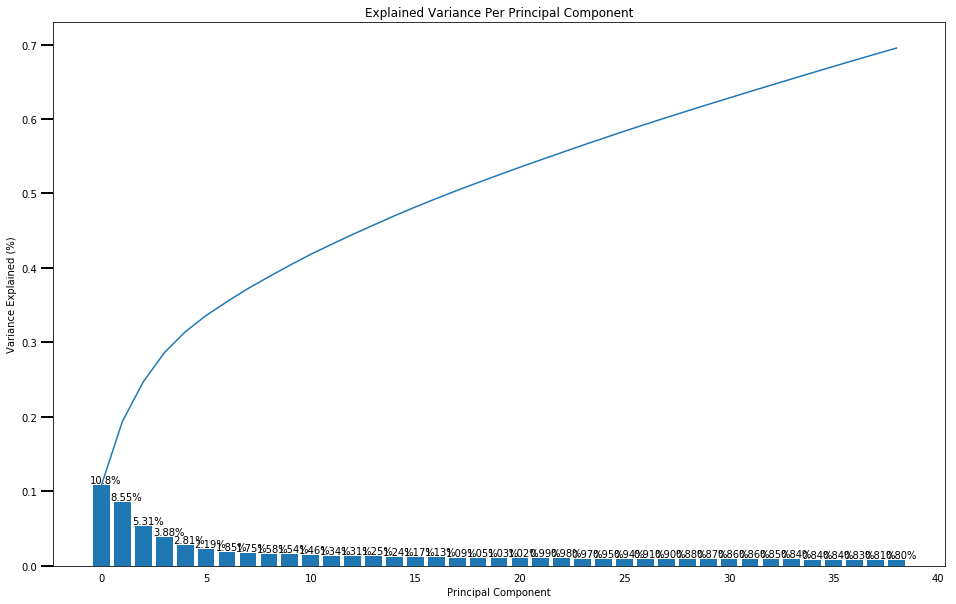

In [215]:
#plot the components and percentage of explained variance for each components 
scree_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction

How many principal components / transformed features are you retaining for the next step of the analysis?
- I used the explained varaince ratio for each component to decide on the number of components that explains 70% of the variance in the data
- The full dataset had 133 features and using PCA only 39 components were enough to explain 70% of the variance in the data which is a reduction by 70%.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [216]:
def pca_result(full_dataset, pca, column_names):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = column_names)
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

In [217]:
pca_result = pca_result(scaled_azdias_df, pca, scaled_azdias_df.columns.values.tolist())

In [218]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
# positive relation to the PCA 1
order = pca_result.loc['Dimension 1'].sort_values(ascending = False)[:5]
for index, value in pca_result.loc['Dimension 1'][order.index].iteritems():
    print('Linked column is {} with a weighted of {}'. format(index, value))

Linked column is LP_STATUS_GROB_1.0 with a weighted of 0.1971
Linked column is HH_EINKOMMEN_SCORE with a weighted of 0.1834
Linked column is PLZ8_ANTG3 with a weighted of 0.1787
Linked column is wealth with a weighted of 0.1772
Linked column is family_home_PLZ8 with a weighted of 0.1632


In [219]:
# negative correlations
order = pca_result.loc['Dimension 1'].sort_values()[:5]
for index, value in pca_result.loc['Dimension 1'][order.index].iteritems():
    print('Linked column is {} with a weighted of {}'. format(index, value))

Linked column is FINANZ_MINIMALIST with a weighted of -0.2072
Linked column is MOBI_REGIO with a weighted of -0.2011
Linked column is KBA05_ANTG1 with a weighted of -0.189
Linked column is KBA05_GBZ with a weighted of -0.1789
Linked column is PLZ8_ANTG1 with a weighted of -0.1729


In [220]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# 2nd component positive relationship attributes or features
order = pca_result.loc['Dimension 2'].sort_values(ascending = False)[:5]
for index, value in pca_result.loc['Dimension 2'][order.index].iteritems():
    print('Linked column is {} with a weighted of {}'. format(index, value))

Linked column is ALTERSKATEGORIE_GROB with a weighted of 0.2198
Linked column is FINANZ_VORSORGER with a weighted of 0.2019
Linked column is ZABEOTYP_3 with a weighted of 0.1986
Linked column is SEMIO_ERL with a weighted of 0.1856
Linked column is RETOURTYP_BK_S with a weighted of 0.1487


In [221]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# 2nd component positive relationship attributes or features
order = pca_result.loc['Dimension 2'].sort_values()[:5]
for index, value in pca_result.loc['Dimension 2'][order.index].iteritems():
    print('Linked column is {} with a weighted of {}'. format(index, value))

Linked column is decade with a weighted of -0.2223
Linked column is SEMIO_REL with a weighted of -0.2143
Linked column is FINANZ_SPARER with a weighted of -0.2026
Linked column is FINANZ_UNAUFFAELLIGER with a weighted of -0.2017
Linked column is SEMIO_PFLICHT with a weighted of -0.2005


In [222]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

order = pca_result.loc['Dimension 3'].sort_values(ascending = False)[:5]
for index, value in pca_result.loc['Dimension 3'][order.index].iteritems():
    print('Linked column is {} with a weighted of {}'. format(index, value))

Linked column is SEMIO_VERT with a weighted of 0.3256
Linked column is SEMIO_SOZ with a weighted of 0.2623
Linked column is SEMIO_FAM with a weighted of 0.2557
Linked column is SEMIO_KULT with a weighted of 0.2412
Linked column is FINANZTYP_5 with a weighted of 0.1411


In [223]:
order = pca_result.loc['Dimension 3'].sort_values()[:5]
for index, value in pca_result.loc['Dimension 3'][order.index].iteritems():
    print('Linked column is {} with a weighted of {}'. format(index, value))

Linked column is ANREDE_KZ with a weighted of -0.3485
Linked column is SEMIO_KAEM with a weighted of -0.3169
Linked column is SEMIO_DOM with a weighted of -0.2874
Linked column is SEMIO_KRIT with a weighted of -0.2652
Linked column is SEMIO_ERL with a weighted of -0.1944


### Discussion 2.3: Interpret Principal Components

reporting your observations from detailed investigation of the first few principal components generated. 
Can we interpret positive and negative values from them in a meaningful way?

**first Component**
looking into 5 relvant features from positive and negative relationship:

- LP_STATUS_GROB_1.0 with a weighted of 0.1971 : low income
- HH_EINKOMMEN_SCORE with a weighted of 0.1848 : Household net income 
- PLZ8_ANTG3 with a weighted of 0.1787 : Number of 6-10 family houses in the PLZ8 region
- wealth with a weighted of 0.1772.
- family_home_PLZ8 with a weighted of 0.1632
*negative relation*
- FINANZ_MINIMALIST with a weighted of -0.2072:  low financial interest
- MOBI_REGIO with a weighted of -0.201: Movement patterns
- KBA05_ANTG1 with a weighted of -0.189: Number of 1-2 family houses
- KBA05_GBZ with a weighted of -0.1789: Number of buildings
- PLZ8_ANTG1 with a weighted of -0.1729: Number of 1-2 family houses

- it seems that most of the features that contribute to the first component with the highest weights are related to finanical status and income. we notice that bigger homes and low income has higher weight than small family houses.

**Second Component**
- ALTERSKATEGORIE_GROB with a weighted of 0.2198: Age
- FINANZ_VORSORGER with a weighted of 0.2019: be prepared Financial typology
- ZABEOTYP_3 with a weighted of 0.1986: Energy consumption fair
- SEMIO_ERL with a weighted of 0.1856: event-oriented personality
- RETOURTYP_BK_S with a weighted of 0.1487: Return type
 
- decade with a weighted of -0.2223: generation
- SEMIO_REL with a weighted of -0.2143: religious personality
- FINANZ_SPARER with a weighted of -0.2026: money saver type
- FINANZ_UNAUFFAELLIGER with a weighted of -0.2017: inconspicuous spending type
- SEMIO_PFLICHT with a weighted of -0.2005: dutiful type 

- it seems this component represents the age, personality and shopping type with the older generation that is more traditional, religious and dutiful having a higher weight that is negative.

**Third Component**
- SEMIO_VERT with a weighted of 0.3256: dreamful personality
- SEMIO_SOZ with a weighted of 0.2623: socially-minded
- SEMIO_FAM with a weighted of 0.2557: family-minded
- SEMIO_KULT with a weighted of 0.2423: cultural-minded
- FINANZTYP_5 with a weighted of 0.1411: investor financial type 
 
- ANREDE_KZ with a weighted of -0.3485: gender
- SEMIO_KAEM with a weighted of -0.3169: combative attitude
- SEMIO_DOM with a weighted of -0.2874: dominant-minded
- SEMIO_KRIT with a weighted of -0.2652: critical-minded
- SEMIO_ERL with a weighted of -0.1944: event-oriented personality
 
- This component is mostly associated with the personality and the gender. it seem to represent the combative, dominant, critical and dreamful personalities that higher weight than family and culutral personals. 

it is hard to understand the components since it can have different meanings and combinations and is prone to bias and speculations.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [224]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
from sklearn.cluster import KMeans
from workspace_utils import active_session

def get_kmeans_score(data, cluster):
    # instantiate kmeans
    kmeans = KMeans(cluster)
     #fit model
    model = kmeans.fit(data)
    #get score of the model
    score = np.abs(model.score(data))
    print('Score: {}'.format(score))
    return score

clusters = list(range(10,21))
scores = []
with active_session():
    for cluster in clusters:
        print('Number of cluster {}'.format(cluster))
        scores.append(get_kmeans_score(X_pca, cluster))

Number of cluster 10
Score: 32823080.27610979
Number of cluster 11
Score: 32468238.681647968
Number of cluster 12
Score: 32006450.884994168
Number of cluster 13
Score: 31823028.004700296
Number of cluster 14
Score: 31537999.93453899
Number of cluster 15
Score: 31254406.77816438
Number of cluster 16
Score: 31013454.31134195
Number of cluster 17
Score: 30584503.236007556
Number of cluster 18
Score: 30319389.2970003
Number of cluster 19
Score: 30119355.215149403
Number of cluster 20
Score: 29990291.249307483


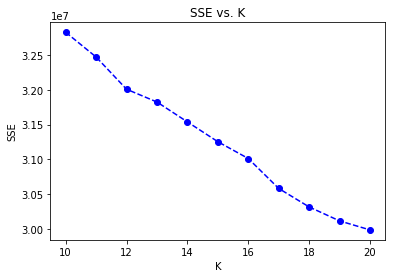

In [225]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(clusters, scores, linestyle ='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [226]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
from sklearn.cluster import KMeans
choosen_k = 18
kmeans_azdias = KMeans(choosen_k)
kmeans_azdias.fit(X_pca)
labels_azdias = kmeans_azdias.transform(X_pca)

In [227]:
KM_labels_population = kmeans_azdias.predict(X_pca)
KM_labels_population

array([10,  2, 12, ..., 14, 10, 12], dtype=int32)

In [228]:
kmeans_azdias.labels_

array([10,  2, 12, ..., 14, 10, 12], dtype=int32)

### Discussion 3.1: Apply Clustering to General Population

Findings and decisions regarding clustering. Into how many clusters 
have you decided to segment the population?

- The number of clusters is: 18
- The best K was choosen using the elbow method. In the elbow method we plot the average distance for the points in the cluster from the center and the best point corresponds to the K value were increasing K value further reduce small changes in the distance. 
- Though the elbow is not clear from the plot. i decided to choose 18 since the decrease in error after this value was minimal.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [229]:
clean_azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541555 entries, 0 to 541554
Columns: 132 entries, ALTERSKATEGORIE_GROB to business_home_PLZ8
dtypes: float64(132)
memory usage: 545.4 MB


In [236]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [237]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
cleaned_customers_df = clean_data(customers)
cleaned_customers_df.info()

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


<class 'pandas.core.frame.DataFrame'>
Int64Index: 139068 entries, 0 to 191651
Columns: 131 entries, ALTERSKATEGORIE_GROB to business_home_PLZ8
dtypes: float64(44), int64(24), int8(1), uint8(62)
memory usage: 81.6 MB
before dropna final None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 107143 entries, 0 to 191651
Columns: 131 entries, ALTERSKATEGORIE_GROB to business_home_PLZ8
dtypes: float64(44), int64(24), int8(1), uint8(62)
memory usage: 62.8 MB


In [238]:
# missing columns in customer dataset
[col for col in clean_azdias.columns.values.tolist() if col not in cleaned_customers_df.columns.values.tolist()]

['GEBAEUDETYP_5.0']

In [239]:
customers.GEBAEUDETYP.value_counts()

1.0    95145
3.0    23655
8.0    20475
2.0     2057
4.0      251
6.0      142
Name: GEBAEUDETYP, dtype: int64

we notice that the reason for the missing columns is the lack of some values in the customers data set so that one hot encoding resulted in less columns that in the full population dataset. so to solve this issue i added the columns to the customers dataset but filled these columns with 0 value. 

In [240]:
## add missing columns and fill with 0
cleaned_customers_df['GEBAEUDETYP_5.0'] = 0
cleaned_customers_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107143 entries, 0 to 191651
Columns: 132 entries, ALTERSKATEGORIE_GROB to GEBAEUDETYP_5.0
dtypes: float64(44), int64(25), int8(1), uint8(62)
memory usage: 63.7 MB


In [241]:
cleaned_customers_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_9,decade,movement,wealth,life_stage,neighbourhood_quality,rural_neighbourhood,family_home_PLZ8,business_home_PLZ8,GEBAEUDETYP_5.0
0,4.0,1,5,1,5,1,2,2,1,1.0,...,0,2.0,1.0,1.0,3.0,0.0,1,1.0,0,0
2,4.0,2,5,1,5,1,4,4,1,2.0,...,0,2.0,1.0,3.0,4.0,2.0,0,3.0,0,0
4,3.0,1,3,1,4,4,5,2,0,3.0,...,0,4.0,0.0,4.0,1.0,3.0,0,2.0,0,0
5,3.0,1,5,1,5,1,2,3,1,3.0,...,0,2.0,1.0,3.0,4.0,1.0,0,1.0,0,0
6,4.0,1,5,1,5,1,1,2,1,2.0,...,0,2.0,1.0,2.0,3.0,0.0,1,1.0,0,0


In [242]:
[col for col in cleaned_customers_df.columns.values.tolist() if col not in clean_azdias.columns.values.tolist()]

[]

In [244]:
customers_imp = imp.transform(cleaned_customers_df)
cleaned_customers_df = pd.DataFrame(cleaned_customers_df,columns=cleaned_customers_df.columns)

In [245]:
cleaned_customers_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107143 entries, 0 to 191651
Columns: 132 entries, ALTERSKATEGORIE_GROB to GEBAEUDETYP_5.0
dtypes: float64(44), int64(25), int8(1), uint8(62)
memory usage: 63.7 MB


so now both datasets contain the same number of columns.

In [246]:
#transformation
scaled_customers = scaler.transform(cleaned_customers_df)

In [247]:
#PCA transformation
X_pca_customers = pca.transform(scaled_customers)

In [248]:
#kmeans transformation
k_labels_customers = kmeans_azdias.predict(X_pca_customers)

In [249]:
k_labels_customers

array([ 5, 11,  7, ...,  5,  2,  5], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [250]:
column_names_population = scaled_azdias_df.columns.values.tolist()

In [251]:
# customer labels count and proportion
customer_labels, customer_label_count = np.unique(k_labels_customers, return_counts=True)
df_customer_labels = pd.DataFrame({"cluster_label":customer_labels,
                                  "customer_label_count": customer_label_count})
df_customer_labels

,cluster_label,customer_label_count
0,0,4345
1,1,310
2,2,1273
3,3,10410
4,4,3823
5,5,47344
6,6,2263
7,7,2430
8,8,364
9,9,298


In [252]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
population_labels, population_label_count = np.unique(KM_labels_population, return_counts=True)
df_population_labels = pd.DataFrame({"cluster_label":population_labels,
                                  "population_label_count": population_label_count})
df_population_labels

,cluster_label,population_label_count
0,0,28470
1,1,28714
2,2,33761
3,3,35920
4,4,32077
5,5,39118
6,6,2204
7,7,28464
8,8,40821
9,9,34378


In [253]:
df_cluster_counts = df_customer_labels.merge(df_population_labels, on='cluster_label')

In [254]:
df_cluster_counts

,cluster_label,customer_label_count,population_label_count
0,0,4345,28470
1,1,310,28714
2,2,1273,33761
3,3,10410,35920
4,4,3823,32077
5,5,47344,39118
6,6,2263,2204
7,7,2430,28464
8,8,364,40821
9,9,298,34378


In [255]:
df_cluster_counts['customer_label_percentage'] = df_cluster_counts['customer_label_count']/df_cluster_counts['customer_label_count'].sum()
df_cluster_counts

,cluster_label,customer_label_count,population_label_count,customer_label_percentage
0,0,4345,28470,0.040553
1,1,310,28714,0.002893
2,2,1273,33761,0.011881
3,3,10410,35920,0.097160
4,4,3823,32077,0.035681
5,5,47344,39118,0.441877
6,6,2263,2204,0.021121
7,7,2430,28464,0.022680
8,8,364,40821,0.003397
9,9,298,34378,0.002781


In [256]:
df_cluster_counts['population_label_percentage'] = df_cluster_counts['population_label_count']/df_cluster_counts['population_label_count'].sum()
df_cluster_counts

,cluster_label,customer_label_count,population_label_count,customer_label_percentage,population_label_percentage
0,0,4345,28470,0.040553,0.052571
1,1,310,28714,0.002893,0.053021
2,2,1273,33761,0.011881,0.062341
3,3,10410,35920,0.097160,0.066328
4,4,3823,32077,0.035681,0.059231
5,5,47344,39118,0.441877,0.072233
6,6,2263,2204,0.021121,0.004070
7,7,2430,28464,0.022680,0.052560
8,8,364,40821,0.003397,0.075377
9,9,298,34378,0.002781,0.063480


In [257]:
df_cluster_counts["difference"] = df_cluster_counts["customer_label_percentage"] - df_cluster_counts["population_label_percentage"]
df_cluster_counts = df_cluster_counts[['cluster_label','customer_label_percentage', 'population_label_percentage', 'difference']]
df_cluster_counts

,cluster_label,customer_label_percentage,population_label_percentage,difference
0,0,0.040553,0.052571,-0.012018
1,1,0.002893,0.053021,-0.050128
2,2,0.011881,0.062341,-0.050460
3,3,0.097160,0.066328,0.030832
4,4,0.035681,0.059231,-0.023550
5,5,0.441877,0.072233,0.369644
6,6,0.021121,0.004070,0.017052
7,7,0.022680,0.052560,-0.029880
8,8,0.003397,0.075377,-0.071980
9,9,0.002781,0.063480,-0.060699


In [268]:
df_cluster_counts.sort_values(by='difference')

,cluster_label,customer_label_percentage,population_label_percentage,difference
10,10,0.003976,0.081085,-0.077109
8,8,0.003397,0.075377,-0.071980
9,9,0.002781,0.063480,-0.060699
2,2,0.011881,0.062341,-0.050460
1,1,0.002893,0.053021,-0.050128
16,16,0.012591,0.061765,-0.049174
17,17,0.016688,0.049751,-0.033063
7,7,0.022680,0.052560,-0.029880
13,13,0.033236,0.056897,-0.023661
4,4,0.035681,0.059231,-0.023550


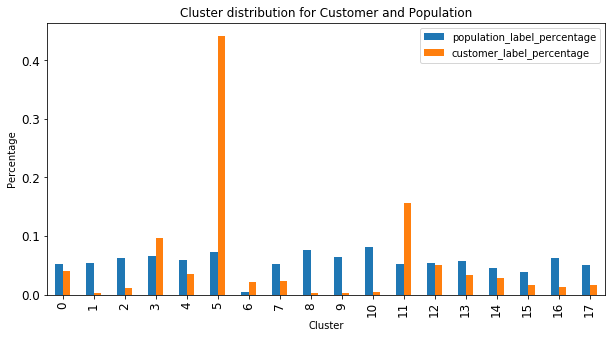

In [258]:
df_cluster_counts[["population_label_percentage", "customer_label_percentage"]].plot(kind="bar",figsize = [10, 5], fontsize=12);
plt.xlabel('Cluster');
plt.ylabel('Percentage');
plt.title('Cluster distribution for Customer and Population');

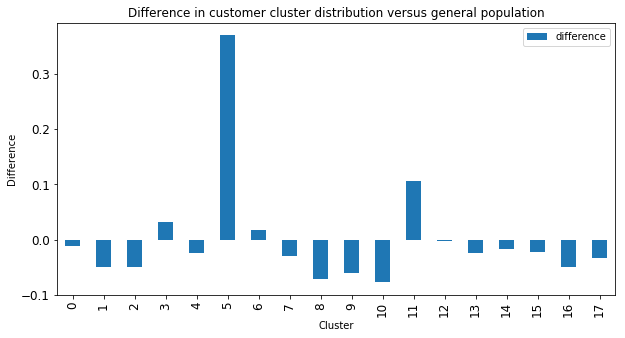

In [259]:
df_cluster_counts[["difference"]].plot(kind="bar",figsize = [10, 5], fontsize=12);
plt.xlabel('Cluster');
plt.ylabel('Difference');
plt.title('Difference in customer cluster distribution versus general population');

In [262]:
df_cluster_counts.sort_values(by='difference', ascending=False)[:3]

,cluster_label,customer_label_percentage,population_label_percentage,difference
5,5,0.441877,0.072233,0.369644
11,11,0.156986,0.051474,0.105512
3,3,0.097160,0.066328,0.030832


In [266]:
df_cluster_counts.sort_values(by='difference')[:7]

,cluster_label,customer_label_percentage,population_label_percentage,difference
10,10,0.003976,0.081085,-0.077109
8,8,0.003397,0.075377,-0.071980
9,9,0.002781,0.063480,-0.060699
2,2,0.011881,0.062341,-0.050460
1,1,0.002893,0.053021,-0.050128
16,16,0.012591,0.061765,-0.049174
17,17,0.016688,0.049751,-0.033063


Summary:
- We can see that cluster 5 is the highest overpresented cluster for the customers followed by cluster 11, 3. 
- underpresented clusters are those with more than 4% clusters 10, 8, 9, 2, 1, 16.
- if we want to target custmers we need to focus on under-represented clusters and avoid over-represented cluster.

In [269]:
def map_PCA_features(pca, pca_component_num, column_names):
    'map the principle components to original dataset'
    pca_num = pca_component_num - 1
    mapping = pca.components_[pca_num]
    dict_to_df = {"col": column_names,
                 'PC_weight': mapping}
    df = pd.DataFrame(dict_to_df, columns=["col", "PC_weight"]).sort_values(by='PC_weight', axis =0, ascending=False)
    return df

In [270]:
# i will look into 3 components of PCA and to the first 5 features of each 
pc1 = map_PCA_features(pca, 1, column_names_population).head()
pc2 = map_PCA_features(pca, 2, column_names_population).head()
pc3 = map_PCA_features(pca, 3, column_names_population).head()

In [271]:
pc_map = pd.concat([pc1, pc2, pc3])
pc_map

,col,PC_weight
90,LP_STATUS_GROB_1.0,0.197110
30,HH_EINKOMMEN_SCORE,0.183367
54,PLZ8_ANTG3,0.178692
126,wealth,0.177152
130,family_home_PLZ8,0.163237
0,ALTERSKATEGORIE_GROB,0.219766
4,FINANZ_VORSORGER,0.201914
104,ZABEOTYP_3,0.198560
18,SEMIO_ERL,0.185641
11,RETOURTYP_BK_S,0.148650


i will use the columns in the pc to compare the over presented and unpresnted stats between the population and customers.

In [272]:
important_columns = pc_map.col.values.tolist()

In [273]:
important_columns

['LP_STATUS_GROB_1.0',
 'HH_EINKOMMEN_SCORE',
 'PLZ8_ANTG3',
 'wealth',
 'family_home_PLZ8',
 'ALTERSKATEGORIE_GROB',
 'FINANZ_VORSORGER',
 'ZABEOTYP_3',
 'SEMIO_ERL',
 'RETOURTYP_BK_S',
 'SEMIO_VERT',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_KULT',
 'FINANZTYP_5']

In [274]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
overpresneted_list = cleaned_customers_df[(k_labels_customers == 5) |(k_labels_customers == 11) | (k_labels_customers ==  3)][important_columns]
overpresneted_list.head()

,LP_STATUS_GROB_1.0,HH_EINKOMMEN_SCORE,PLZ8_ANTG3,wealth,family_home_PLZ8,ALTERSKATEGORIE_GROB,FINANZ_VORSORGER,ZABEOTYP_3,SEMIO_ERL,RETOURTYP_BK_S,SEMIO_VERT,SEMIO_SOZ,SEMIO_FAM,SEMIO_KULT,FINANZTYP_5
0,0,1.0,1.0,1.0,1.0,4.0,5,1,3,5.0,6,6,5,4,0
2,0,1.0,3.0,3.0,3.0,4.0,5,1,7,5.0,3,2,2,1,0
5,0,1.0,2.0,3.0,1.0,3.0,5,0,4,3.0,7,6,4,6,1
6,0,2.0,1.0,2.0,1.0,4.0,5,0,3,5.0,6,4,2,4,0
7,0,1.0,1.0,1.0,1.0,4.0,5,1,3,5.0,7,6,4,4,1


In [275]:
# mode values of overpresented list
overpresneted_list.mode().T

,0
LP_STATUS_GROB_1.0,0.0
HH_EINKOMMEN_SCORE,1.0
PLZ8_ANTG3,1.0
wealth,1.0
family_home_PLZ8,1.0
ALTERSKATEGORIE_GROB,4.0
FINANZ_VORSORGER,5.0
ZABEOTYP_3,0.0
SEMIO_ERL,3.0
RETOURTYP_BK_S,5.0


The overpresented customers list consist of customers with the following attributes:


1)  mainly 1-2 family homes in PLZ8

2)  no low-income earners

3)  estimated high income : highest income 

4)  lower share of 6-10 family homes in PLZ8 region

5)  wealthy households

6) > 60 years old

7) be prepared (VORSORGER) Financial group. very low

8) no fair supplied energy consumption

9) high affinity event-oriented group

10) determined Minimal-Returner

11) lowest affinity dreamful person

12) very low affinity socially-minded

13) average family person

14) average cultural-minded person

15) non-investor type

In [276]:
overpresneted_list.describe().T

,count,mean,std,min,25%,50%,75%,max
LP_STATUS_GROB_1.0,74574.0,0.021884,0.146307,0.0,0.0,0.0,0.0,1.0
HH_EINKOMMEN_SCORE,74574.0,2.701424,1.448548,1.0,1.0,3.0,4.0,6.0
PLZ8_ANTG3,74574.0,1.194666,0.745838,0.0,1.0,1.0,2.0,3.0
wealth,74574.0,2.318462,1.308234,1.0,1.0,2.0,4.0,5.0
family_home_PLZ8,74574.0,1.146539,0.472212,1.0,1.0,1.0,1.0,4.0
ALTERSKATEGORIE_GROB,74574.0,3.642959,0.549647,1.0,3.0,4.0,4.0,4.0
FINANZ_VORSORGER,74574.0,4.793239,0.511844,1.0,5.0,5.0,5.0,5.0
ZABEOTYP_3,74574.0,0.379972,0.485383,0.0,0.0,0.0,1.0,1.0
SEMIO_ERL,74574.0,4.717609,1.750783,1.0,3.0,4.0,7.0,7.0
RETOURTYP_BK_S,74574.0,3.979416,1.132875,1.0,3.0,4.0,5.0,5.0


In [279]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
underpresneted_list = cleaned_customers_df[(k_labels_customers ==  10) |(k_labels_customers == 8) | (k_labels_customers == 9) | (k_labels_customers ==  2) |(k_labels_customers == 1) | (k_labels_customers ==  16)][important_columns]
underpresneted_list.head()

,LP_STATUS_GROB_1.0,HH_EINKOMMEN_SCORE,PLZ8_ANTG3,wealth,family_home_PLZ8,ALTERSKATEGORIE_GROB,FINANZ_VORSORGER,ZABEOTYP_3,SEMIO_ERL,RETOURTYP_BK_S,SEMIO_VERT,SEMIO_SOZ,SEMIO_FAM,SEMIO_KULT,FINANZTYP_5
107,0,5.0,2.0,1.0,1.0,3.0,3,1,6,3.0,4,2,1,3,0
141,1,5.0,2.0,4.0,1.0,3.0,4,0,6,5.0,2,5,3,3,0
341,0,4.0,1.0,2.0,1.0,3.0,4,0,4,5.0,7,6,5,5,1
346,0,4.0,1.0,1.0,1.0,1.0,1,0,1,1.0,6,7,7,7,0
382,0,4.0,2.0,1.0,1.0,3.0,4,0,4,3.0,5,3,6,6,0


In [280]:
underpresneted_list.mode().T

,0
LP_STATUS_GROB_1.0,0.0
HH_EINKOMMEN_SCORE,5.0
PLZ8_ANTG3,2.0
wealth,2.0
family_home_PLZ8,1.0
ALTERSKATEGORIE_GROB,3.0
FINANZ_VORSORGER,4.0
ZABEOTYP_3,0.0
SEMIO_ERL,4.0
RETOURTYP_BK_S,5.0


The underpresented customers list consist of customers with the following attributes:

1)  mainly 1-2 family homes in PLZ8

2)  no low-income earners

3)  estimated high income : lower income

4)  average share of 6-10 family homes in PLZ8 region

5)  Prosperous Households

6) age group: 46 - 60 years old

7) be prepared (VORSORGER) Financial group low

8) no fair supplied energy consumption

9) event_oriented: average affinity

10) determined Minimal-Returner

11) low dreamful person

12) very high affinity socially-minded

13) low family person

14)  low affinity cultural-minded person

15) non-investor type

In [281]:
# compare underpresented and over presented groups
underpresneted_list.describe().T

,count,mean,std,min,25%,50%,75%,max
LP_STATUS_GROB_1.0,4020.0,0.368159,0.482365,0.0,0.0,0.0,1.0,1.0
HH_EINKOMMEN_SCORE,4020.0,4.677114,1.088849,1.0,4.0,5.0,5.0,6.0
PLZ8_ANTG3,4020.0,1.576617,0.780995,0.0,1.0,2.0,2.0,3.0
wealth,4020.0,2.864428,1.362702,1.0,2.0,3.0,4.0,5.0
family_home_PLZ8,4020.0,1.449254,0.832687,1.0,1.0,1.0,2.0,4.0
ALTERSKATEGORIE_GROB,4020.0,2.465672,0.845971,1.0,2.0,3.0,3.0,4.0
FINANZ_VORSORGER,4020.0,3.410697,1.302565,1.0,2.0,4.0,4.0,5.0
ZABEOTYP_3,4020.0,0.253483,0.435059,0.0,0.0,0.0,1.0,1.0
SEMIO_ERL,4020.0,4.296020,1.535816,1.0,4.0,4.0,6.0,7.0
RETOURTYP_BK_S,4020.0,3.402239,1.374833,1.0,2.0,3.0,5.0,5.0


In [282]:
# compare the under and over presented groups
pd.DataFrame({"column_name": important_columns,
                               "under_represented": underpresneted_list.mode().iloc[0].tolist(),
                               "over_represented": overpresneted_list.mode().iloc[0].tolist()})

,column_name,under_represented,over_represented
0,LP_STATUS_GROB_1.0,0.0,0.0
1,HH_EINKOMMEN_SCORE,5.0,1.0
2,PLZ8_ANTG3,2.0,1.0
3,wealth,2.0,1.0
4,family_home_PLZ8,1.0,1.0
5,ALTERSKATEGORIE_GROB,3.0,4.0
6,FINANZ_VORSORGER,4.0,5.0
7,ZABEOTYP_3,0.0,0.0
8,SEMIO_ERL,4.0,3.0
9,RETOURTYP_BK_S,5.0,5.0


### Comparing the two group we notice that: 
- LP_STATUS_GROB_1.0: low income earners are not present in any of the under or over represented groups.
- HH_EINKOMMEN_SCORE: under has more lower income compared to the presence of the highest income in the over represented. 
- PLZ8_ANTG3: under-represented had more customers with a lower share of 6-10 family homes compared to the average share home in over-represented group.
- wealth: the under has more Prosperous Households compared to more wealthy households prescence in the over represented.
- family_home_PLZ8: mainly 1-2 family homes in PLZ8 are present in both of these groups.
- ALTERSKATEGORIE_GROB: the under re-presented contain more of the 46 - 60 years old compared to age groups of more than 60 years old in the over represented group.
- FINANZ_VORSORGER: low prescence of be prepared Financial typology in the under-represented compared to the very low in over-represented.
- ZABEOTYP_3: both groups did not have fair supply energy consumption.
- SEMIO_ERL: the under-represented group had average event oriented personality compared to a high affinity in the over-represented group.
- RETOURTYP_BK_S: both determined Minimal-Returner
- SEMIO_VERT: under had dreamful with low affinity compared to the lowest affinity in the over-represented group.
- SEMIO_SOZ: socially-minded had a very high affinity in the under group compared to the very low affinity in the over group.
- SEMIO_FAM: family oriented had a low affinity compared to average affinity in the over group.
- SEMIO_KULT: cultural-minded had the low affinity compared to average affinity in the over group.
- FINANZTYP_5: both had a similar prescene of no investors.

### Discussion 3.3: Compare Customer Data to Demographics Data
Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?

- popular include the highest income people, age group above 60 years, wealthy households, event-oriented individuals including family and culutral minded groups with more of traditional attributes direction.
- unpopular include lower age groups, less prescence of low income and less affluent households and in terms of personality socially minded, low family and cultural minded groups are under presented.


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.